## Geospatial Data Scientist Census Activity
**Author:** Nicole Pepper

**Date:** 11/21/2025

**GitHub Repo:** https://github.com/nicolelpepper/af-census-activity

### 1) Set Up Workspace

In [29]:
# ---- Load libraries ----
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import re
from rasterio.mask import mask
import rasterstats
from rasterio.plot import show
import matplotlib.pyplot as plt


### 2) Load Project Data

In [30]:
# ---- Read in project data ----

# american community survey data
acs = pd.read_csv("data/raw/ACSDP5Y2023.DP05_2025-11-17T173744/ACSDP5Y2023.DP05-Data.csv")

# landcover data
landcover = rasterio.open("data/raw/landcover/landcover_conus.tif")

# schools data
private_schools = gpd.read_file("data/raw/schools/EDGE_GEOCODE_PRIVATESCH_2122/EDGE_GEOCODE_PRIVATESCH_2122.shp")
public_schools = gpd.read_file("data/raw/schools/EDGE_GEOCODE_PUBLICSCH_2324/EDGE_GEOCODE_PUBLICSCH_2324.shp")

# census tracts data for 2025 (choose a state)
florida_tracts = gpd.read_file("data/raw/tracts/12/tl_2025_12_tract.shp").to_crs(landcover.crs)
# oregon_tracts = gpd.read_file("data/raw/tracts/41/tl_2025_41_tract.shp")
# pennsylvania_tracts = gpd.read_file("data/raw/tracts/42/tl_2025_42_tract.shp")

/var/folders/f1/_qnbjphx7mvb9p2c19t_s1540000gn/T/ipykernel_56239/1859539031.py:4: DtypeWarning: Columns (2,3,4,5,6,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,58,59,60,61,62,63,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,238,246,254,324,338,372) have mixed types. Specify dtype option on import or set low_memory=False.
  acs = pd.read_csv("data/raw/ACSDP5Y2023.DP05_2025-11-17T173744/ACSDP5Y2023.DP05-Data.csv")


### 3) Clean Data

##### Prep American Community Survey (acs) Data

In [31]:
# --- Explore  & prep american community survey data ----

# Check column names
acs.columns

# Get snapshot of data
acs.head

# Save 1st row as metadata for columns (bc there are two header rows)
metadata_row = acs.iloc[0]
col_metadata = metadata_row.to_dict()
print(col_metadata)

# Drop extra header and reset index
acs = acs.drop(index=0).reset_index(drop=True)
acs.head

# ---- Select demographic data for Florida ----

# Select primary id fields and 2 demographic statistics of choice: 0037PE (percent white) and 0075PE (percent hispanic)
acs = acs[["GEO_ID", "NAME", "DP05_0001E","DP05_0037PE", "DP05_0075PE"]] 

# filter to Florida
fl_acs = acs[acs["GEO_ID"].str.contains("1400000US12")]

# ---- Clean errors in population statistics columns ----

# Select population statistics columns
pop_cols = ["DP05_0001E","DP05_0037PE","DP05_0075PE"]

# Force non-numeric values to NA
fl_acs[pop_cols] = fl_acs[pop_cols].apply(
    pd.to_numeric,
    errors="coerce")

fl_acs

{'GEO_ID': 'Geography', 'NAME': 'Geographic Area Name', 'DP05_0001E': 'Estimate!!SEX AND AGE!!Total population', 'DP05_0001M': 'Margin of Error!!SEX AND AGE!!Total population', 'DP05_0002E': 'Estimate!!SEX AND AGE!!Total population!!Male', 'DP05_0002M': 'Margin of Error!!SEX AND AGE!!Total population!!Male', 'DP05_0003E': 'Estimate!!SEX AND AGE!!Total population!!Female', 'DP05_0003M': 'Margin of Error!!SEX AND AGE!!Total population!!Female', 'DP05_0004E': 'Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)', 'DP05_0004M': 'Margin of Error!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)', 'DP05_0005E': 'Estimate!!SEX AND AGE!!Total population!!Under 5 years', 'DP05_0005M': 'Margin of Error!!SEX AND AGE!!Total population!!Under 5 years', 'DP05_0006E': 'Estimate!!SEX AND AGE!!Total population!!5 to 9 years', 'DP05_0006M': 'Margin of Error!!SEX AND AGE!!Total population!!5 to 9 years', 'DP05_0007E': 'Estimate!!SEX AND AGE!!Total population!!10 to 

/var/folders/f1/_qnbjphx7mvb9p2c19t_s1540000gn/T/ipykernel_56239/1741720929.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fl_acs[pop_cols] = fl_acs[pop_cols].apply(


,GEO_ID,NAME,DP05_0001E,DP05_0037PE,DP05_0075PE
0,1400000US12001000201,Census Tract 2.01; Alachua County; Florida,5187,72.5,5187
1,1400000US12001000202,Census Tract 2.02; Alachua County; Florida,5897,73.5,5897
2,1400000US12001000301,Census Tract 3.01; Alachua County; Florida,3703,73.5,3703
3,1400000US12001000302,Census Tract 3.02; Alachua County; Florida,2500,60.3,2500
4,1400000US12001000400,Census Tract 4; Alachua County; Florida,5736,51.5,5736
...,...,...,...,...,...
5155,1400000US12133970104,Census Tract 9701.04; Washington County; Florida,2564,86.9,2564
5156,1400000US12133970200,Census Tract 9702; Washington County; Florida,3225,88.4,3225
5157,1400000US12133970301,Census Tract 9703.01; Washington County; Florida,2712,87.4,2712
5158,1400000US12133970302,Census Tract 9703.02; Washington County; Florida,7094,65.0,7094


##### Prep Schools Data

In [32]:
# ---- Explore & prep schools data -----

# Explore data
public_schools.head
private_schools.head

# Add descriptive column for schools
public_schools["school_type"] = "public_schools"
private_schools["school_type"] = "private_schools"

# Join schools data
schools = pd.concat([public_schools, private_schools], ignore_index = True)

In [33]:
# --- Count schools in florida tracts ----

# Left join with florida tracts 
schools_in_florida = gpd.sjoin(
    florida_tracts,
    schools,
    how = "left",
    predicate = "intersects")


# Count schools per tract unique tract using GEOID
school_counts = (schools_in_florida
                 .groupby(["GEOIDFQ","school_type"])
                 .size()
                 .unstack(fill_value=0)
                 .reset_index())

/var/folders/f1/_qnbjphx7mvb9p2c19t_s1540000gn/T/ipykernel_56239/2813664313.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84" ...
Right CRS: EPSG:4269

  schools_in_florida = gpd.sjoin(


##### Prep landcover data

In [ ]:
# ---- Clip landcover data to Florida ----

# Dissolve florida tracts to get clipping boundary
fl_union = florida_tracts.unary_union

# Clip landcover to Florida
lc_clip, lc_transform = mask(landcover, [fl_union], crop=True)
lc_array = lc_clip[0]       # first band
lc_nodata = landcover.nodata

/var/folders/f1/_qnbjphx7mvb9p2c19t_s1540000gn/T/ipykernel_56239/3210577174.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fl_union = florida_tracts.unary_union


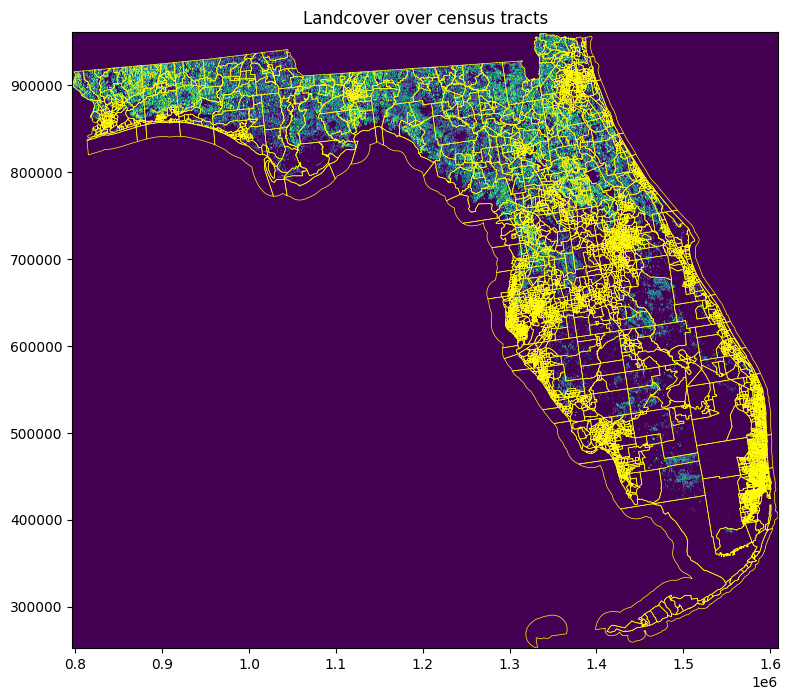

In [ ]:
# ---- Check out landcover and census tracts ----

fig, ax = plt.subplots(figsize=(10, 8))

# Plot florida landcover
show(lc_array, ax=ax, transform=lc_transform)
# Add Florida census tracts
florida_tracts.boundary.plot(ax=ax, edgecolor="yellow", linewidth=0.5)

ax.set_title("Landcover over census tracts in Florida")
plt.show()

In [34]:
# ---- Prep landcover data to extract spatial stats -----

landcover_path = "data/raw/landcover/landcover_conus.tif" # Need this still?

landcover_array = landcover.read(1)
affine = landcover.transform

# --- Define landcover classes of interest ----
forest_classes = [41, 42, 43]
water_classes = [11, 12]


In [35]:
# ---- Calculating zonal statistics ----
landcover_count = zonal_stats(
    florida_tracts,
    landcover_array,
    affine = affine,
    categorical = "True",
    nodata = -128)

In [36]:
landcover_count

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {42: 137},
 {},
 {42: 54},
 {},
 {},
 {},
 {},
 {},
 {},
 {41: 1, 42: 4, 43: 4},
 {42: 28},
 {},
 {},
 {},
 {},
 {},
 {},
 {42: 9},
 {},
 {},
 {42: 39, 43: 4},
 {41: 145, 42: 18722, 43: 73},
 {41: 523, 42: 72091, 43: 94},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {42: 113},
 {},
 {},
 {41: 1, 42: 17},
 {42: 36},
 {},
 {42: 48},
 {42: 18},
 {42: 5},
 {},
 {},
 {42: 8},
 {},
 {},
 {},
 {41: 3, 42: 12},
 {42: 7},
 {},
 {},
 {42: 3},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {42: 7, 43: 7},
 {42: 1144, 43: 47},
 {42: 22, 43: 8},
 {41: 11, 42: 938, 43: 39},
 {42: 149, 43: 7},
 {42: 33},
 {42: 180, 43: 47},
 {41: 4, 42: 371, 43: 36},
 {42: 232},
 {41: 7, 42: 507, 43: 7},
 {41: 56, 42: 2994, 43: 16},
 {41: 3, 42: 141},
 {42: 21},
 {42: 6, 43: 12},
 {42: 2},
 {},
 {41: 7, 42: 284, 43: 99},
 {42: 63, 43: 33},
 {},
 {41: 112, 42: 1944, 43: 471},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {42: 5},
 {},
 {42: 10},
 {},
 {},
 {42: 238},


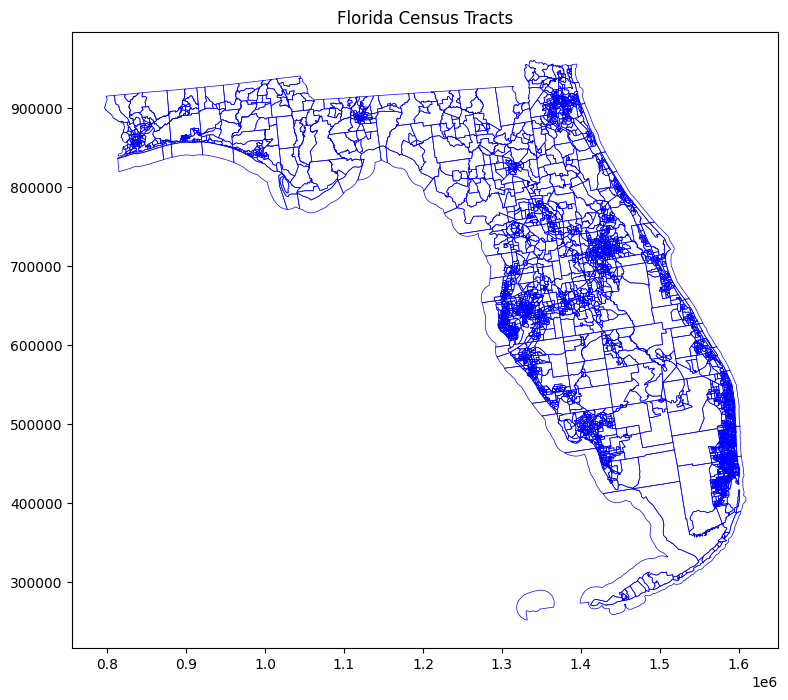

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

florida_tracts.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=0.5
)

ax.set_title("Florida Census Tracts")
plt.show()


In [38]:
\

SyntaxError: unexpected EOF while parsing (3477860531.py, line 1)

In [ ]:
lc_stats = pd.DataFrame({
    "GEOIDFQ": tracts_geo["GEOIDFQ"].values,
    "forest_pixels": forest_pixels,
    "total_land_pixels": total_land_pixels
})

florida_tracts = florida_tracts.merge(lc_stats, on="GEOIDFQ", how="left")

### 4) Merge Datasets

In [ ]:
# ---- Merge acs data to florida tracts ----

# Left merge school counts on florida tracts
florida_tracts = florida_tracts.merge(
    fl_acs,
    how = "left",
    left_on = "GEOIDFQ",
    right_on = "GEO_ID")


In [ ]:
# ---- Merge school data to florida tracts ---

# Left merge school counts on florida tracts
florida_tracts = florida_tracts.merge(
    school_counts,
    how = "left",
    on = "GEOIDFQ")

# Fill in NAs for no schools with 0s
florida_tracts[["public_schools", "private_schools"]] = (
    florida_tracts[["public_schools", "private_schools"]].fillna(0))

In [ ]:
florida_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,geometry,GEO_ID,NAME_y,DP05_0001E,DP05_0037PE,DP05_0075PE,private_schools,public_schools,pct_forest_x,pct_forest_y
0,12,099,004300,12099004300,1400000US12099004300,43,Census Tract 43,G5020,S,4826118,...,"POLYGON ((1587934.002 533733.196, 1588081.634 ...",1400000US12099004300,Census Tract 43; Palm Beach County; Florida,6244,70.0,6244,1.0,1.0,0.000000,0.000000
1,12,099,004500,12099004500,1400000US12099004500,45,Census Tract 45,G5020,S,2905159,...,"POLYGON ((1588669.527 528907.64, 1588660.523 5...",1400000US12099004500,Census Tract 45; Palm Beach County; Florida,7869,29.8,7869,0.0,0.0,0.000000,0.000000
2,12,099,004602,12099004602,1400000US12099004602,46.02,Census Tract 46.02,G5020,S,1984760,...,"POLYGON ((1586198.151 528804.865, 1586191.407 ...",1400000US12099004602,Census Tract 46.02; Palm Beach County; Florida,5209,29.5,5209,0.0,1.0,0.000000,0.000000
3,12,099,004702,12099004702,1400000US12099004702,47.02,Census Tract 47.02,G5020,S,2645473,...,"POLYGON ((1584763.513 527162.559, 1584746.269 ...",1400000US12099004702,Census Tract 47.02; Palm Beach County; Florida,7441,23.2,7441,0.0,2.0,0.000000,0.000000
4,12,099,004704,12099004704,1400000US12099004704,47.04,Census Tract 47.04,G5020,S,2657506,...,"POLYGON ((1584581.135 528373.084, 1584577.408 ...",1400000US12099004704,Census Tract 47.04; Palm Beach County; Florida,7093,32.1,7093,2.0,2.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,12,057,011805,12057011805,1400000US12057011805,118.05,Census Tract 118.05,G5020,S,1447981,...,"POLYGON ((1324898.42 646153.471, 1324977.418 6...",1400000US12057011805,Census Tract 118.05; Hillsborough County; Florida,3894,42.2,3894,0.0,0.0,1.159420,0.579515
5156,12,057,011911,12057011911,1400000US12057011911,119.11,Census Tract 119.11,G5020,S,2077714,...,"POLYGON ((1327631.528 642357.329, 1327629.313 ...",1400000US12057011911,Census Tract 119.11; Hillsborough County; Florida,6139,42.9,6139,0.0,0.0,0.774860,0.387365
5157,12,057,002702,12057002702,1400000US12057002702,27.02,Census Tract 27.02,G5020,S,1235845,...,"POLYGON ((1328503.86 638881.199, 1328492.825 6...",1400000US12057002702,Census Tract 27.02; Hillsborough County; Florida,2806,41.0,2806,0.0,0.0,0.000000,0.000000
5158,12,091,023100,12091023100,1400000US12091023100,231,Census Tract 231,G5020,S,6557738,...,"POLYGON ((881036.658 857152.038, 881013.444 85...",1400000US12091023100,Census Tract 231; Okaloosa County; Florida,8609,60.1,8609,0.0,1.0,1.205074,0.602511


### 6) Calculate Spatial Statistics

In [ ]:
# ---- Calculate school statistics ----

# Calculate total schools per tract
florida_tracts["total_schools"] = (florida_tracts["public_schools"] + florida_tracts["private_schools"])

# Calculate schools per capita
florida_tracts["schools_per_capita"] = (florida_tracts["total_schools"]/ florida_tracts["DP05_0001E"])

# Calculate schools per capita
florida_tracts["schools_per_1000"] = florida_tracts["schools_per_capita"] * 1000